In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import pypyodbc
import os.path
import os,sys
from datetime import datetime, timedelta
import logging
from dotenv import load_dotenv
load_dotenv()

#Start Automation Process
logger = logging.getLogger("Automation")
logger.setLevel(logging.INFO)
if logger.hasHandlers():
    logger.handlers.clear()
file_handler = logging.FileHandler("Automation.log")
file_handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s:%(levelname)s:%(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

logger.info("******** Automation Process *********")


In [2]:
t = datetime.now() - timedelta(8)
today = datetime.strftime(t, '%m/%d/%Y')
today

'04/27/2022'

In [3]:
#prod connection
driver = os.getenv("DRIVER")
server = os.getenv("SERVER_PROD")
database = os.getenv("DATABASE")
uid = os.getenv("UID_PROD")
pwd = os.getenv("PWD_PROD")


In [4]:
conn = pypyodbc.connect("Driver={"+driver+"};Server="+server+";Database="+database+";uid="+uid+";pwd="+pwd)

t = datetime.now() - timedelta(8)
today = datetime.strftime(t, '%m/%d/%Y')

#FL_FLIGHT_DETAILS
flight_query = """select * from FL_FLIGHT_DETAILS where FL_ACTUAL_TIME >='03/01/2022' and FL_ACTUAL_TIME <= '""" + today + "'"
flight_details = pd.read_sql_query(flight_query, conn)
print(flight_details.shape)

flight_details = flight_details.sort_values(by='fl_internal_key').reset_index(drop=True)
flight_details['fl_internal_key'] = flight_details['fl_internal_key'].astype(int)
internal_key = flight_details.fl_internal_key.values[0]
internal_key = internal_key.astype(str)
print(internal_key)

#FL_SUMMARY_COUNT
conn = pypyodbc.connect("Driver={"+driver+"};Server="+server+";Database="+database+";uid="+uid+";pwd="+pwd)

summary_query = """select * from FL_SUMMARY_COUNT where fl_internal_key>='""" + internal_key + "'"
summary_data = pd.read_sql_query(summary_query, conn)
print(summary_data.shape)

#TB_ACTIVEFLIGHT 
conn = pypyodbc.connect("Driver={"+driver+"};Server="+server+";Database="+database+";uid="+uid+";pwd="+pwd)

active_flight_query = """SELECT * FROM TB_ACTIVEFLIGHT where STAD >= '03/01/2021' and STAD <= '""" + today + "'"
active_flight_data = pd.read_sql_query(active_flight_query, conn)
print(active_flight_data.shape)

#TB_STAND
conn = pypyodbc.connect("Driver={"+driver+"};Server="+server+";Database="+database+";uid="+uid+";pwd="+pwd)

Bay_standcode_query = """SELECT * FROM TB_STAND"""
Bay_standcode = pd.read_sql_query(Bay_standcode_query, conn)
print(Bay_standcode.shape)
Bay_standcode = Bay_standcode.rename(columns={'bay':'BAY','terminal':'TERMINAL','oper_type':'Oper_Type'})


(17595, 18)
3863734
(323739, 10)
(339447, 86)
(434, 11)


In [5]:
flight_details.to_csv('Flight_Details.csv',index=False)
summary_data.to_csv('Summary_Data.csv',index=False)
active_flight_data.to_csv('Active_Flights.csv',index=False)
Bay_standcode.to_csv('Bay_Stand.csv',index=False)

In [6]:
a_summary = summary_data[(summary_data['fl_leg']=='A') & (summary_data['fl_type_name'].isin(['o-d','transfer']))][['fl_internal_key','fl_afskey','fl_leg','fl_type_name','fl_type_count']].reset_index(drop=True)
a_summary = a_summary.groupby(['fl_afskey','fl_leg'])['fl_type_count'].sum().reset_index()
a_summary = a_summary[a_summary['fl_afskey']!=0]

d_summary = summary_data[(summary_data['fl_leg']=='D') & (summary_data['fl_type_name'].isin(['o-d','transfer','transit','transitinfants']))][['fl_internal_key','fl_afskey','fl_leg','fl_type_name','fl_type_count']].reset_index(drop=True)
d_summary = d_summary.groupby(['fl_afskey','fl_leg'])['fl_type_count'].sum().reset_index()
d_summary = d_summary[d_summary['fl_afskey']!=0]

a_d_summary = pd.concat([a_summary,d_summary]).reset_index(drop=True)

#merge of activeflight & summary details

flight_details1 = flight_details[['fl_internal_key','fl_afskey','fl_tail_registration','fl_actual_time','fl_leg','fl_aircraft_type','fl_routing']]
flight_details1['fl_routing'] = flight_details1['fl_routing'].str.strip()
flight_details1['fl_routing'] = flight_details1.apply(lambda val: val.fl_routing.split(",")[-1] if val.fl_leg =='D' else val.fl_routing.split(",")[0],axis=1)
flight_details1 = pd.merge(flight_details1,a_d_summary,how='left',on=['fl_afskey','fl_leg'])
flight_details1 = flight_details1[flight_details1['fl_afskey']!=0]

#active flight
active_flight_data['standcode'] = active_flight_data['standcode'].str.strip()
active_flight_data['BAY'] = active_flight_data['standcode']
active_flight = active_flight_data[(active_flight_data['modesequence'].isin([0,1])) & (~active_flight_data['remarkcodeflight'].isin(['FCL'])) & (~active_flight_data['tailno'].isin([''])) & (active_flight_data['iataservicetypecode'].isin(['C','G','J']))]

selected_columns_1 = active_flight[['afskey','tailno','aircrafttypecode','leg','station1','station2','station3','station4','station5','station6','iataservicetypecode','stad','atad','standcode','BAY','categorycode']]
today_active_flight= selected_columns_1.copy().reset_index(drop=True)
today_active_flight = today_active_flight.rename(columns={'afskey':'fl_afskey'})

Bay_standcode['BAY'] = Bay_standcode['BAY'].str.strip()
selected_columns_2 = Bay_standcode[['BAY','Oper_Type','TERMINAL']]
passenger_flight = selected_columns_2.copy()

active_passenger_flight = pd.merge(today_active_flight,passenger_flight,how='left',on=['BAY'])
#TB_Active_Flight = active_passenger_flight[(active_passenger_flight['Oper_Type'].isin(['Passenger']))].reset_index(drop=True)


merge_data = pd.merge(active_passenger_flight,flight_details1,how='left',on=['fl_afskey'])
merge_data = merge_data.dropna(subset=['fl_internal_key'])
print(merge_data.shape)

merge_data.to_csv('merge_data_post_covid_IATA.csv',index=False)

flight_details2 = merge_data[['fl_afskey','fl_internal_key','fl_tail_registration','fl_actual_time','fl_leg','fl_aircraft_type','fl_routing','categorycode','TERMINAL','fl_type_count']]
print(flight_details2.shape)

unique_combo = flight_details2.groupby(['fl_tail_registration','fl_leg','fl_routing'])['fl_afskey'].count().reset_index()
unique_combo['Available'] = 'Yes'
unique_combo.to_csv('Unique_combo_post_covid_IATA.csv',index=False)
print(unique_combo.shape)

for_new_combo = flight_details2.groupby(['fl_leg','fl_routing'])['fl_type_count'].mean().reset_index()
print(for_new_combo.shape)

for_new_combo.to_csv('for_new_combo_post_covid_IATA.csv',index=False)

flight_details2.to_csv('flight_level_pax_count2_post_covid_IATA.csv',index=False)

data = pd.read_csv('flight_level_pax_count2_post_covid_IATA.csv')

data['fl_actual_time'] = pd.to_datetime(data['fl_actual_time'],errors='coerce')
data['fl_actual_time'] = data['fl_actual_time'].apply(lambda val : val.strftime('%Y-%m-%d %H:%M:%S'))
data['fl_actual_time'] = pd.to_datetime(data['fl_actual_time'],errors='coerce')

data['hour'] = data['fl_actual_time'].dt.hour

conditions = [
    (data['hour'] < 8),
    (data['hour'] >= 8) & (data['hour'] < 15),
    (data['hour'] >= 15) & (data['hour'] < 21),
    (data['hour'] >= 21)
    ]

values = ['0000 to 0800', '0800 to 1500', '1500 to 2100', '2100 to 2400']

data['shift_time'] = np.select(conditions, values)

data['fl_actual_time'] = pd.to_datetime(data['fl_actual_time'],errors='coerce')
data['fl_actual_time'] = data['fl_actual_time'].apply(lambda val : val.strftime('%Y-%m-%d'))

grp_df = data.groupby(['fl_actual_time'])['fl_type_count'].sum().reset_index()

data['fl_actual_time'] = pd.to_datetime(data['fl_actual_time'],errors='coerce')

print(data.shape)
print(data.fl_routing.nunique())
print(data.fl_aircraft_type.nunique())

def weekinmonth(dates):
    """Get week number in a month.
    
    Parameters: 
        dates (pd.Series): Series of dates.
    Returns: 
        pd.Series: Week number in a month.
    """
    firstday_in_month = dates - pd.to_timedelta(dates.dt.day - 1, unit='d')
    return (dates.dt.day + firstday_in_month.dt.weekday) // 7 + 1
    
    
data['year'] = data['fl_actual_time'].dt.year
data['month'] = data['fl_actual_time'].dt.month
data['week'] = data['fl_actual_time'].dt.week
data['day'] = data['fl_actual_time'].dt.day
data['dayofweek'] = data['fl_actual_time'].dt.dayofweek
data['WOM'] = weekinmonth(data['fl_actual_time'])

temp = data.sort_values('fl_actual_time')
temp = temp.groupby(['fl_tail_registration','fl_routing','fl_leg','categorycode','TERMINAL'])['fl_type_count'].agg(['mean','min','max','median','last']).reset_index()
temp.to_csv('pax_agg_post_covid_IATA.csv',index=False)

data = pd.merge(data,temp,how='left',on=['fl_tail_registration','fl_routing','fl_leg','categorycode','TERMINAL'])


<ipython-input-6-04581f61c121>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_details1['fl_routing'] = flight_details1['fl_routing'].str.strip()
<ipython-input-6-04581f61c121>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_details1['fl_routing'] = flight_details1.apply(lambda val: val.fl_routing.split(",")[-1] if val.fl_leg =='D' else val.fl_routing.split(",")[0],axis=1)


(17112, 25)
(17112, 10)
(4316, 5)
(146, 3)
(17112, 12)
75
35


<ipython-input-6-04581f61c121>:101: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data['week'] = data['fl_actual_time'].dt.week


In [7]:
#Model Building
from pycaret.regression import *

exp_1 = setup(data=data,target='fl_type_count',train_size=0.8,
              categorical_features=['fl_tail_registration','fl_leg','fl_routing','categorycode','TERMINAL','shift_time'],
              ignore_features=['fl_actual_time','fl_afskey','fl_internal_key','fl_aircraft_type'],
              numeric_features=['year','month','week','day','dayofweek','WOM','hour','mean','median','min','max','last'],session_id=123,silent=True
             )


,Description,Value
0,session_id,123
1,Target,fl_type_count
2,Original Data,"(17112, 23)"
3,Missing Values,True
4,Numeric Features,12
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(13689, 685)"


In [8]:
best_models = compare_models(include=['lightgbm'])
#best_models = compare_models()


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,17.5898,625.0381,24.9866,0.7550,0.2926,0.2026,0.8660


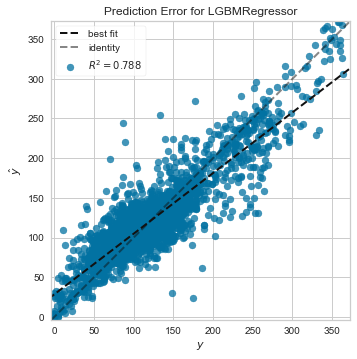

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,17.6599,611.9246,24.7371,0.7880,0.2805,0.2027


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,15.5770,450.7241,21.2303,0.8439,0.2548,0.1810


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['fl_tail_registration',
                                                             'fl_leg',
                                                             'fl_routing',
                                                             'categorycode',
                                                             'TERMINAL',
                                                             'shift_time'],
                                       display_types=False,
                                       features_todrop=['fl_actual_time',
                                                        'fl_afskey',
                                                        'fl_internal_key',
                                                        'fl_aircraft_type'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=

In [9]:
#random forest
rf = create_model('lightgbm')

plot_model(rf, plot = 'error')

#predict on test
predict_model(rf);

#fianlize model
final_rf = finalize_model(rf)
#print(final_rf)

predict_model(final_rf);

save_model(final_rf,'Pax_Prediction_Model_post_covid_IATA')